In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

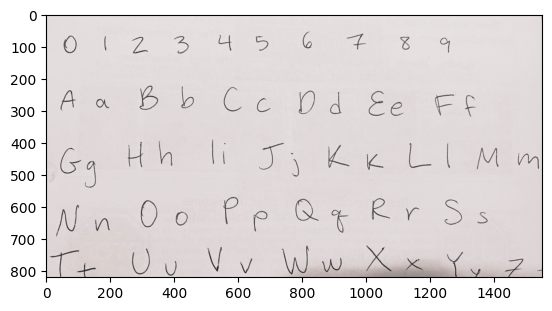

In [18]:
original_image_example_1 = cv2.imread('./data/raw_files/Images/Personal_handwriting/set5.jpg')
plt.imshow(original_image_example_1)

c:\Users\Emily\anaconda3\envs\myenvsept\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


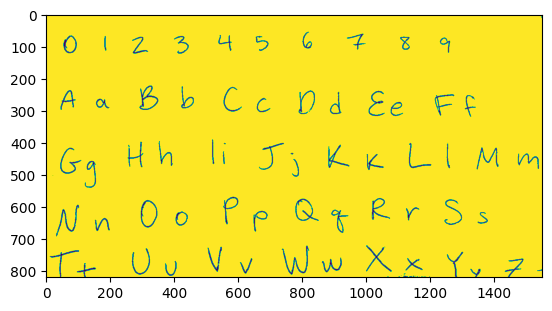

In [19]:

def convert_to_BW(img):
    if 'data' in img:
        layer = cv2.split(cv2.imread(img))[0]
    else:
        layer = cv2.split(img)[0]
    BW_image = []
    for row in layer:
        new_row = [0 if val < 150 else 255 for val in row]
        BW_image.append(new_row)
    BW_image = np.array(BW_image)
    return BW_image

bw_example_1 = convert_to_BW(original_image_example_1)
plt.imshow(bw_example_1)

In [20]:
# save this image and reopen it in order to put boxes around the indivdual letters - if I don't do this, I get an error. 

cv2.imwrite(f'./data/processed_files/BW_Images/example_1.png', bw_example_1)

True

In [21]:
def split_letters_page(path):
    img = cv2.imread(path)

    lower = (0, 80, 110)
    upper = (0, 120, 150)

    mask = cv2.inRange(img, lower, upper)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)

    img[mask==255] = (255,255,255)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU )[1] 

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17,17))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    morph = 255 - morph

    bboxes = []
    bboxes_img = img.copy()
    contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        cv2.rectangle(bboxes_img, (x, y), (x+w, y+h), (0, 0, 255), 1)
        bboxes.append((x,y,w,h))

    def takeFirst(elem):
        return elem[0]

    bboxes.sort(key=takeFirst)

    crops = []

    for i in range(len(bboxes)):
        (x,y,w,h) = bboxes[i]
        crop = img[y-10:y+h+10, x-10:x+w+10]
        crops.append(crop)
    return bboxes_img, crops

In [22]:
boxed_example, example_cropped_list = split_letters_page('./data/processed_files/BW_Images/example_1.png')

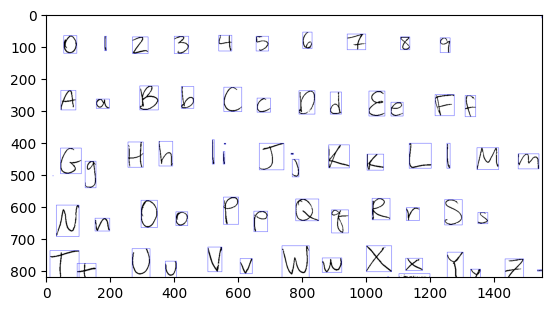

In [23]:
plt.imshow(boxed_example)

In [24]:
def prepare_image(img):
    #layer = cv2.split(cv2.imread(path))[0]
    layer = cv2.split(img)[0]
    new_rows = []
    for row in layer:
        if row.mean() != 255:
            new_rows.append(row)
    new_rows = np.array(new_rows)
    new_columns = []
    for column in new_rows.T:
        if column.mean() != 255:
            new_columns.append(column)
    new_array = np.array(new_columns).T
    # the image should be a square - add whitespace to make it into a square
    width = new_array.shape[1]
    height = new_array.shape[0]
    if width > height+3:
        # add 3 in order to account for images which are already close enough to being squares
        amount_rows_to_add = (width-height)//2
        row_to_add = [255.0 for n in range(width)]
        rows_to_add = np.array([row_to_add for n in range(amount_rows_to_add)])
        new_array = np.vstack([rows_to_add, new_array, rows_to_add])
    if height > width+3:
        transpose = new_array.T
        amount_rows_to_add = (height-width)//2
        row_to_add = [255.0 for n in range(height)]
        rows_to_add = np.array([row_to_add for n in range(amount_rows_to_add)])
        new_array = np.vstack([rows_to_add, transpose, rows_to_add]).T
    return cv2.resize(new_array, (40, 40))

In [27]:
example_letter = prepare_image(example_cropped_list[7])

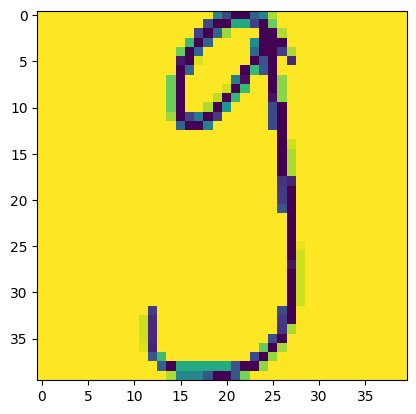

In [28]:
plt.imshow(example_letter)

In [36]:
# some of the boxes surround half a letter or a small line or dot. Remove super small images before saving them 

for i in range(len(example_cropped_list)):
    if example_cropped_list[i].shape[0] < 30:
        print(i)

1
27
34
48
49
51
67
68


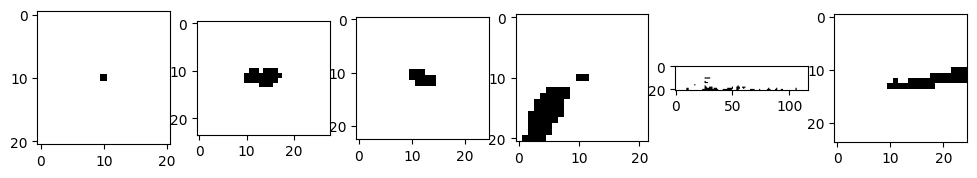

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 5))
ax[0].imshow(example_cropped_list[1])
ax[1].imshow(example_cropped_list[34])
ax[2].imshow(example_cropped_list[27])
ax[3].imshow(example_cropped_list[48])
ax[4].imshow(example_cropped_list[51])
ax[5].imshow(example_cropped_list[67])

In [38]:
# It all looks good! Now lets do it with all the letters and numbers. 

In [52]:
raw_images = [cv2.imread(f'./data/raw_files/Images/Personal_handwriting/{file}') for file in os.listdir(path='./data/raw_files/Images/Personal_handwriting')]
bw_images = [convert_to_BW(img) for img in raw_images]
for i in range(len(bw_images)):
   cv2.imwrite(f'./data/processed_files/BW_Images/bw_set{i}.png', bw_images[i])
all_cropped_images = []
for filename in os.listdir(path='./data/processed_files/BW_Images'):
    boxed_img, cropped_list = split_letters_page(f'./data/processed_files/BW_Images/{filename}')
    for cropped_img in cropped_list:
        if cropped_img.shape[0] < 30:
            pass
        if cropped_img.shape[1] < 30:
            pass
        else:
            all_cropped_images.append(cropped_img)
processed_cropped_images = []
for val in all_cropped_images:
    try:
        processed_cropped_images.append(prepare_image(val))
    except:
        pass
for i in range(len(processed_cropped_images)):
    cv2.imwrite(f'./data/processed_files/My_letters_digits/img{i}.png', processed_cropped_images[i])

c:\Users\Emily\anaconda3\envs\myenvsept\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [40]:
# set 7 looks bad - lets try to fix this

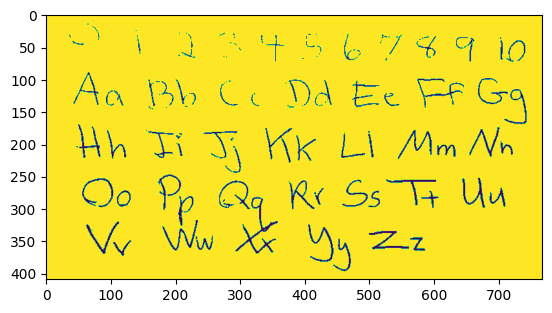

In [42]:
plt.imshow(bw_images[7])

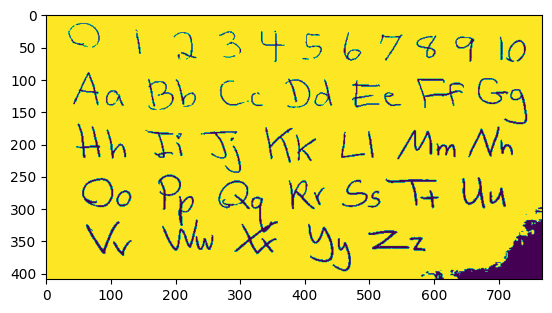

In [49]:

def convert_to_BW_update(img):
    if 'data' in img:
        layer = cv2.split(cv2.imread(img))[0]
    else:
        layer = cv2.split(img)[0]
    BW_image = []
    for row in layer:
        new_row = [0 if val < 180 else 255 for val in row]
        BW_image.append(new_row)
    BW_image = np.array(BW_image)
    return BW_image

bw_example_2 = convert_to_BW_update('./data/raw_files/Images/Personal_handwriting/set8.jpg')
plt.imshow(bw_example_2)

In [53]:
cv2.imwrite(f'./data/processed_files/BW_Images/bw_set7_update.png', bw_example_2)

True

In [55]:
all_cropped_images = []
boxed_imgs = []
for filename in os.listdir(path='./data/processed_files/BW_Images'):
    boxed_img, cropped_list = split_letters_page(f'./data/processed_files/BW_Images/{filename}')
    boxed_imgs.append(boxed_img)
    for cropped_img in cropped_list:
        if cropped_img.shape[0] < 30:
            pass
        if cropped_img.shape[1] < 30:
            pass
        else:
            all_cropped_images.append(cropped_img)
processed_cropped_images = []
for val in all_cropped_images:
    try:
        processed_cropped_images.append(prepare_image(val))
    except:
        pass
for i in range(len(processed_cropped_images)):
    cv2.imwrite(f'./data/processed_files/My_letters_digits/img{i}.png', processed_cropped_images[i])